In [1]:
import assembleFeatureMatrix as afm
import extractSaccFix as esf
import plotData
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore');

c:\Users\kyunomi\anaconda3\envs\cogpilot\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\kyunomi\anaconda3\envs\cogpilot\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Step 2: Explore Oculomotor Aggregate Features

This notebook explores a starter set of statistical features computed on the eye tracking data streams in aggregate over each run. By working through the steps provided here, you will get to know these features and prepare a feature matrix that will be used in Step 3 of the tutorial to train and evaluate a simple predictive model. 


In [2]:
# Assuming the folder "starterCode" is located in the same directory as the folder "dataPackage".
# Otherwise, update the path to the data
dataDir = ".." + os.sep + "dataPackage"

## Extract oculomotor events from gaze data

Here we define outOcuEvtsDir to be the same as the main data package directory, though it does not have to be.
The extractSaccFixDataStream function call is commented out as this processing pipeline may take several hours to complete. For ease of use, the events have been pre-computed and included into the dataPackage. Note the presence of files with the phrase \*ocuevts*.csv, which are the computed oculomotor events. Running extractSaccFixDataStream will regenerate those oculomotor event csv files.

In [3]:
outOcuEvtsDir = dataDir; 
# esf.extractSaccFixDataStream(dataDir, outOcuEvtsDir);

## Aggregate features into a dataFrame

For ease of use, we have included the results of this cell into the starter code package. However, if you delete the data_feats folder, the code below will regenerate the aggregated features. Note that this stage takes 20-30 minutes to run.

In [4]:
expType = 'task-ils'
aggFeatFileDir = "."+os.path.sep+'data_feats';
if (not os.path.exists(aggFeatFileDir)):
    os.makedirs(aggFeatFileDir);

aggFeatFilePath = aggFeatFileDir+os.path.sep+'devSubjsFeatMat.csv'
featMatDF = afm.getFeatureMatrix(dataDir+os.path.sep+expType, aggFeatFilePath, True);

Found precomputed feature matrix.
Loaded into a dataFrame.


In [5]:
display(featMatDF.columns.values)

array(['Unnamed: 0', 'Subject', 'Session', 'Run',
       'overall_gaze_entropy_LX', 'psd_max_LX', 'psd_freq_of_max_LX',
       'overall_gaze_entropy_LY', 'psd_max_LY', 'psd_freq_of_max_LY',
       'overall_gaze_entropy_LZ', 'psd_max_LZ', 'psd_freq_of_max_LZ',
       'overall_gaze_entropy_RX', 'psd_max_RX', 'psd_freq_of_max_RX',
       'overall_gaze_entropy_RY', 'psd_max_RY', 'psd_freq_of_max_RY',
       'overall_gaze_entropy_RZ', 'psd_max_RZ', 'psd_freq_of_max_RZ',
       'eyes_closed_fraction_L', 'eyes_closed_fraction_R',
       'pupil_diam_mean_L', 'pupil_diam_stdev_L', 'pupil_diam_skew_L',
       'pupil_diam_kurt_L', 'pupil_diam_mean_R', 'pupil_diam_stdev_R',
       'pupil_diam_skew_R', 'pupil_diam_kurt_R', 'fix_dur_mean',
       'fix_dur_stdev', 'fix_dur_skew', 'fix_dur_kurt',
       'fix_density_mean', 'fix_density_stdev', 'fix_density_skew',
       'fix_density_kurt', 'sac_main_seq_mean', 'sac_main_seq_stdev',
       'sac_peak_vel_mean', 'sac_peak_vel_stdev'], dtype=object)

## Power Spectral Density (PSD) Features

Power spectral density describes the distribution of frequencies in the raw signal. This can be useful, for example, in providing a sense of the most dominant frequencies in the signal, which would have the highest power in the PSD. In addition, by revealing the spectral profile as a whole, the PSD offers a wealth of insights into the frequency dynamics of the signal.

In this starter set of aggregate features for predictive modeling that we derive from the raw eye tracking signals, we are including several that make use of the PSD. These are computed specifically on the Gaze Direction data, along its three dimensions (X,Y,Z), for each eye (L,R):

* psd_max[...]: the maximum power observed in the PSD distribution

* psd_freq_of_max[...]: the frequency that shows the maximum power in the PSD distribution, i.e. the dominant frequency in the signal

* overall_gaze_entropy[...]: the spectral entropy of the signal, computed as the Shannon entropy of the PSD

To note, prior research has found gaze entropy to be of interest as a correlate of pilot cognitive load:

> "Entropy of eye movements was first explored in a paper by [1] describing the looking behavior of eleven pilots...It was observed that as workload went up, dwell times increased, fixations decreased, and that the dwell times were re-proportioned to the more "important" instruments...As the workload increased, entropy decreased as they started to restrict the range of their eye movement behavior. In a high entropy state, one would expect less focused visual scanning with no predisposition to fixate at any one instrument more than another." [2]

### Power spectral density example

Here, we plot the Power Spectral Density (PSD) for one run. Observe the peak of the PSD in the plot -- the y value of this peak is the maximum PSD, and the x value is the frequency of the maximum. 

[0.0039444  0.00396729 0.0039444  0.00396729 0.0039444  0.00395203
 0.0039444  0.00395966 0.00398254 0.0039444 ]
252.84152652461677


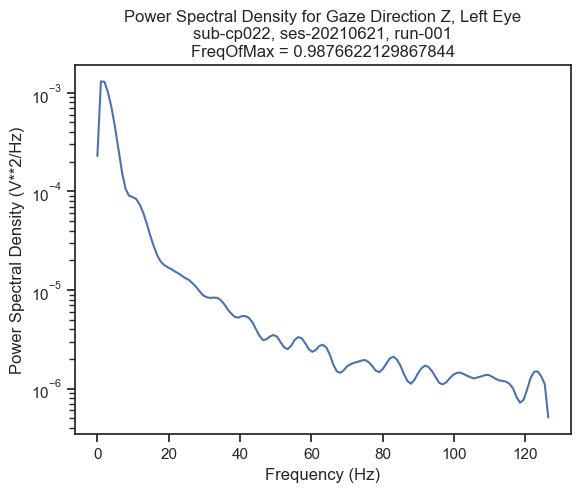

In [6]:
sub022_run001_dfEYE = plotData.loadTimeSeries(dataDir, 
                                              "sub-cp022", 
                                              "ses-20210621", 
                                              "task-ils", 
                                              "lslhtcviveeye",
                                              "level-01B_run-001");

times        = sub022_run001_dfEYE['time_dn'];
timesMillis  = times * 24 * 3600;
diffTimes    = np.diff(timesMillis);
samplingFreq = np.mean(1./diffTimes);
gazeLZ       = sub022_run001_dfEYE['gaze_direction_l_z'];
f, psd       = signal.welch(gazeLZ, samplingFreq);

print(diffTimes[0:10])

print(samplingFreq)

psdMaxPowerIdx = np.argmax(psd)
psdFreqOfMax   = f[psdMaxPowerIdx];

#plt.plot(f, psd)
plt.semilogy(f, psd)
plt.xlabel('Frequency (Hz)');
plt.ylabel('Power Spectral Density (V**2/Hz)');
plt.title('Power Spectral Density for Gaze Direction Z, Left Eye\n' \
          'sub-cp022, ses-20210621, run-001\nFreqOfMax = '+str(psdFreqOfMax));
plt.show();

### Visualizing PSD-derived features across subjects

In [7]:
dataDir+os.path.sep+expType+os.path.sep+"PerfMetrics.csv"

'..\\dataPackage\\task-ils\\PerfMetrics.csv'

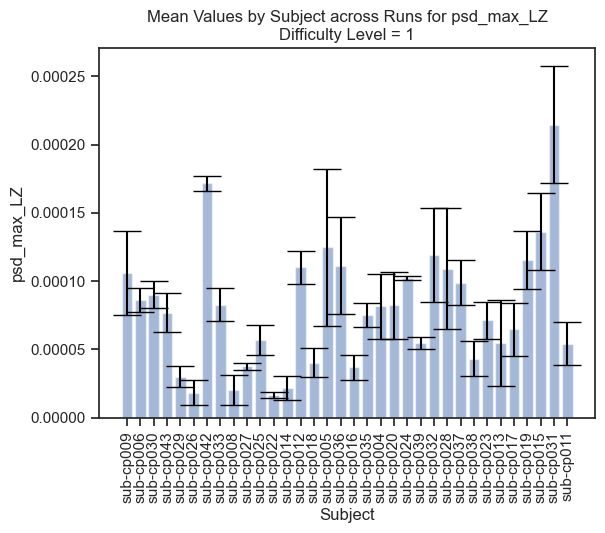

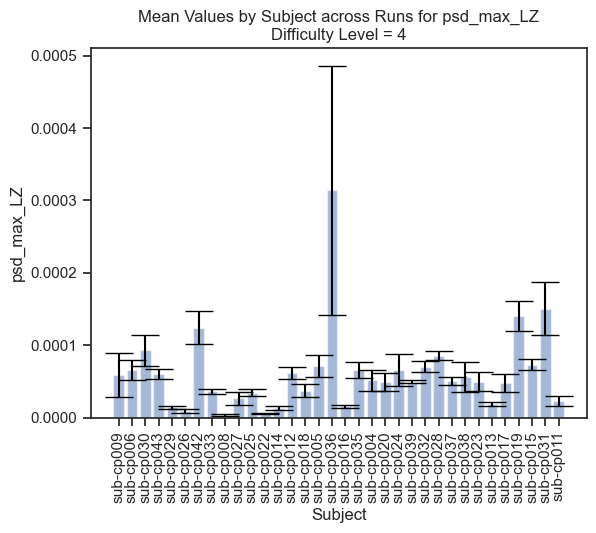

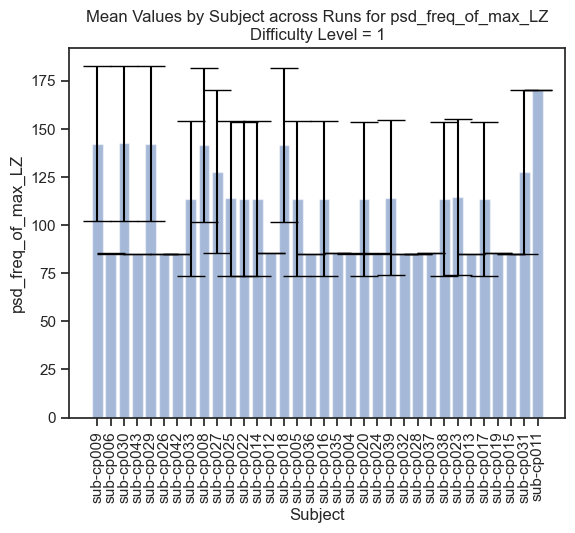

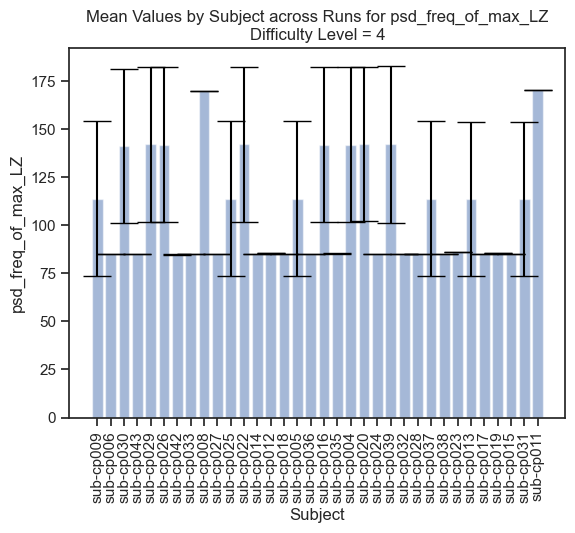

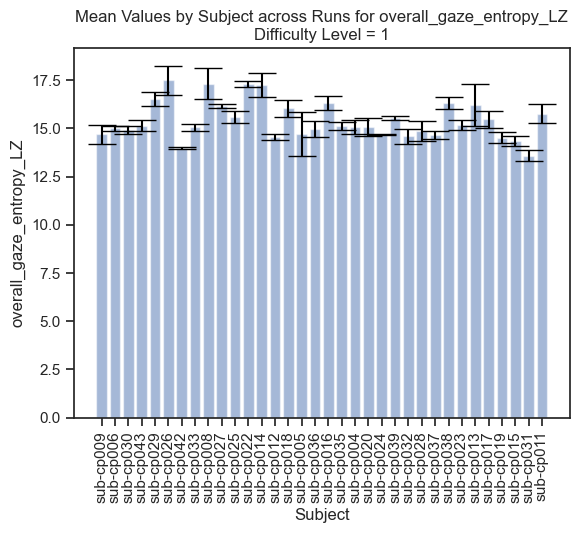

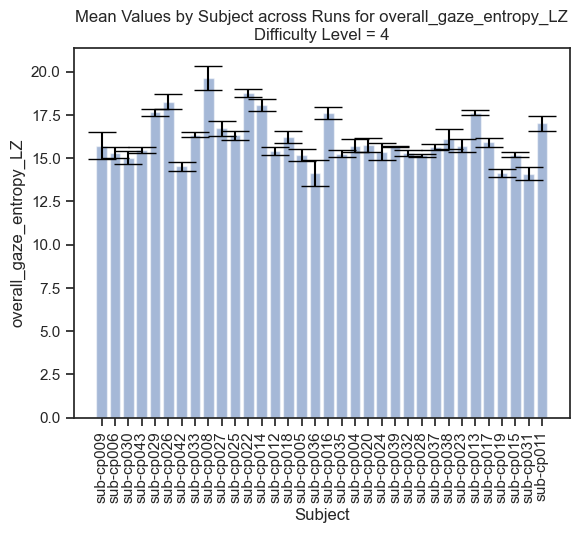

In [8]:
perfMetricsDF = pd.read_csv(dataDir+os.path.sep+expType+os.path.sep+"PerfMetrics.csv");

plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'psd_max_LZ');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'psd_max_LZ');

plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'psd_freq_of_max_LZ');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'psd_freq_of_max_LZ');

plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'overall_gaze_entropy_LZ');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'overall_gaze_entropy_LZ');


# Fraction of Time Eyes Closed

Eye blinking is an automatic movement that also responds to voluntary control. The involuntary component is known to be influenced by stress and anxiety [3], shifts in cognitive processing and attention [4], as well as fatigue and mental load [5,6]. In addition, as blinks naturally induce a temporary loss of vision, the ability to voluntarily adapt one's blinking for a given task to minimize visual interruptions tends to correlate with better task performance [7]. 

As a rough indicator of eye blinking activity during a run, we provide the fraction of time that the eyes are closed as an aggregate feature. This is done by applying a threshold of 0.5 to the eye_openness_l and eye_openness_r fields in the eye tracking data file. Thus, values > 0.5 mean the eye is open, and otherwise meaning the eye is closed. The number of time samples during which the eye is closed is then divided by the total number of time samples to get final value.

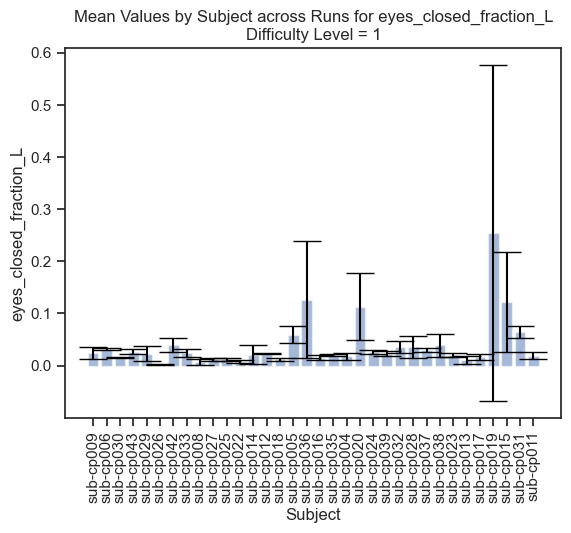

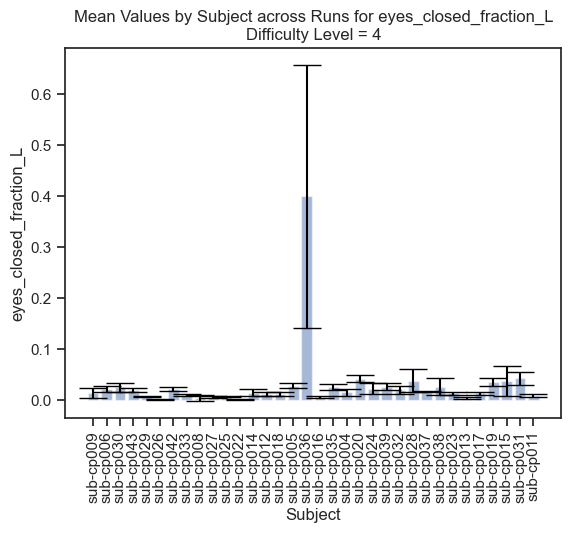

In [9]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'eyes_closed_fraction_L');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'eyes_closed_fraction_L');

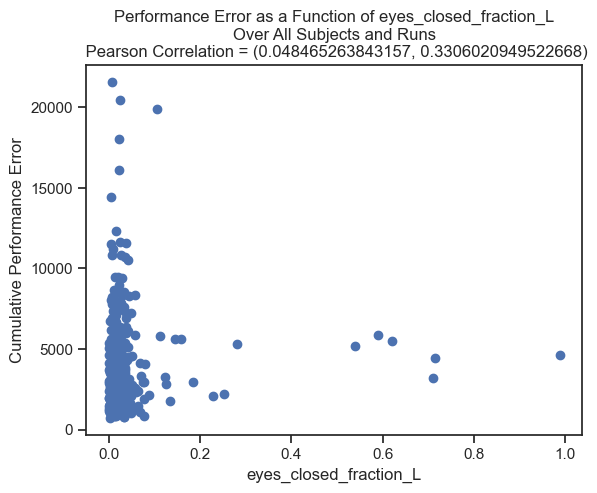

In [10]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'eyes_closed_fraction_L');

# Pupil Diameter

Pupil diameter is known to reflect changes in brain state, including perceptual shifts, emotional state, and autonomic nervous system activity [8,9,10]. Using the pupil diameter information provided as part of the eye tracking data, we compute some simple aggregate statistics over each run: mean, standard deviation, skewness, and kurtosis.

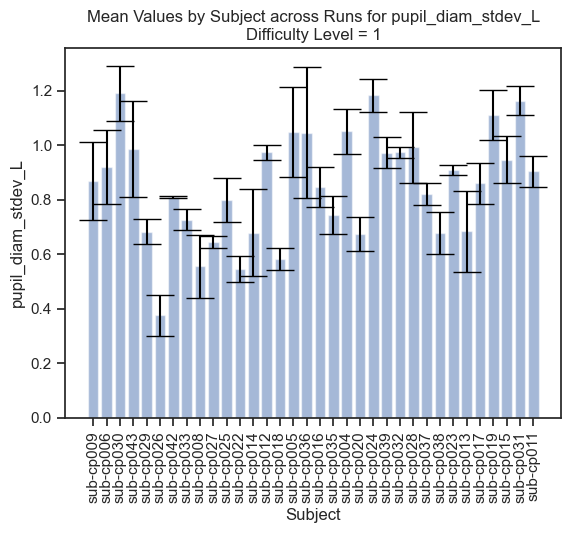

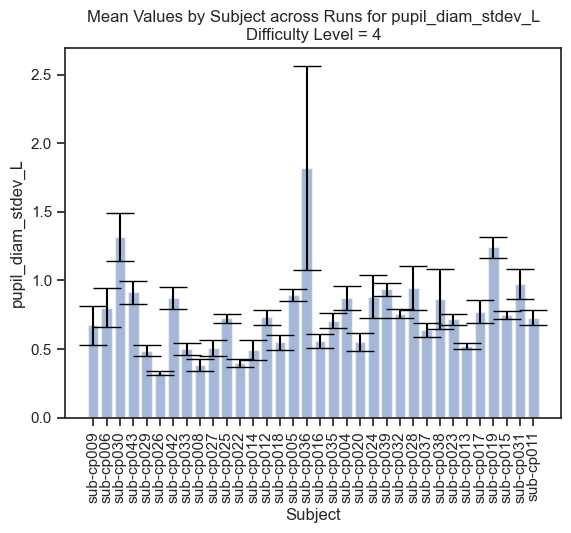

In [11]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'pupil_diam_stdev_L');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'pupil_diam_stdev_L');

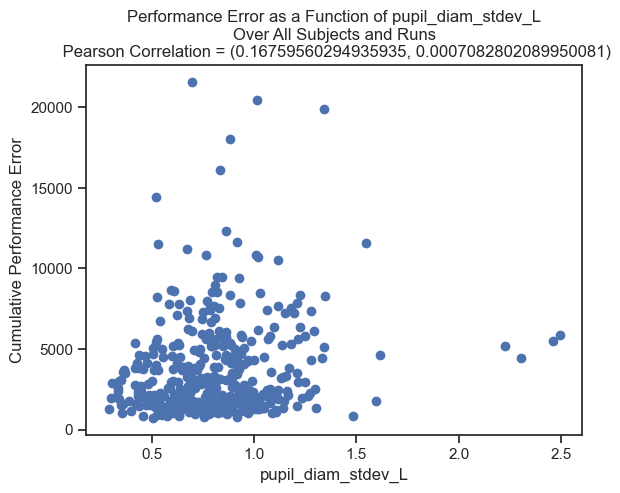

In [12]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'pupil_diam_stdev_L');

# Eye Movement Events

Human vision is an active process in which eye movements are essential to visual perception and clarity [11]. High visual acuity in humans is restricted to the fovea, a 1.5mm spot in the center of the retina that is densely packed with cone photoreceptors [12]. Studies such as [13] have shown that an image stabilized on the retina rapidly disappears from visual perception. Thus, to maintain a continuous and sharp visual perception of the world around us, our eyes must be in constant motion.

A **saccade** is a type of eye movement event in which the eye moves efficiently from one point of interest to another. During the high-velocity motion of a saccade, the eye cannot perceive any visual target, but once the saccade ends, the eye pauses in a brief **fixation**, enabling the retina to capture the visual image. Even during a fixation, however, the eyes stay in motion on a smaller scale, constantly refreshing the visual image on the retina before it fades. 

We have applied the PyTrack library [14] to extract the sequence of saccades and fixations over time from the eye tracking data. From this data, we compute the following aggregate features to characterize eye movement behaviors for each run:


## Fixation Duration 

For each fixation, we compute its duration in milliseconds. To characterize the distribution of fixation durations across all fixations in a run, we calculate average, standard deviation, kurtosis, and skewness as aggregate features.

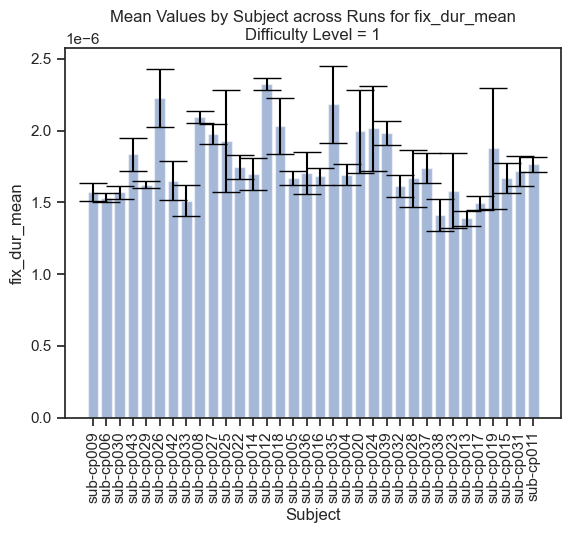

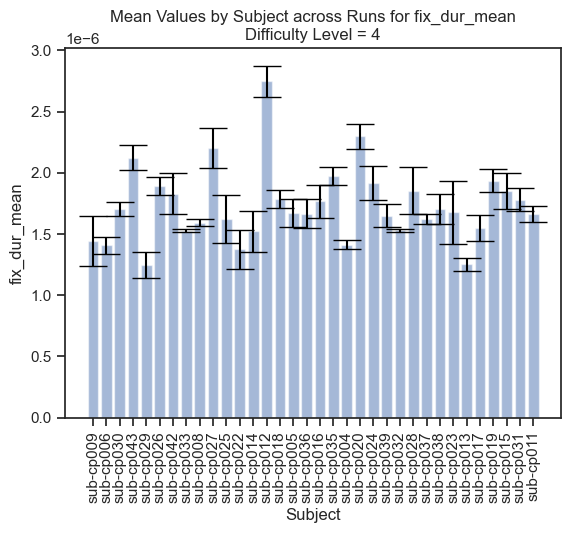

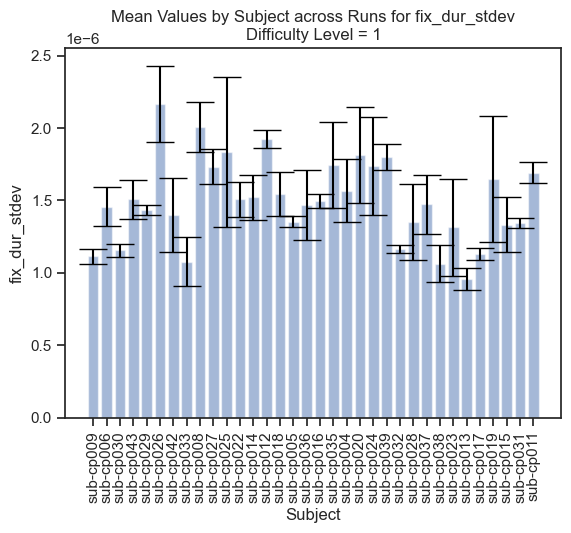

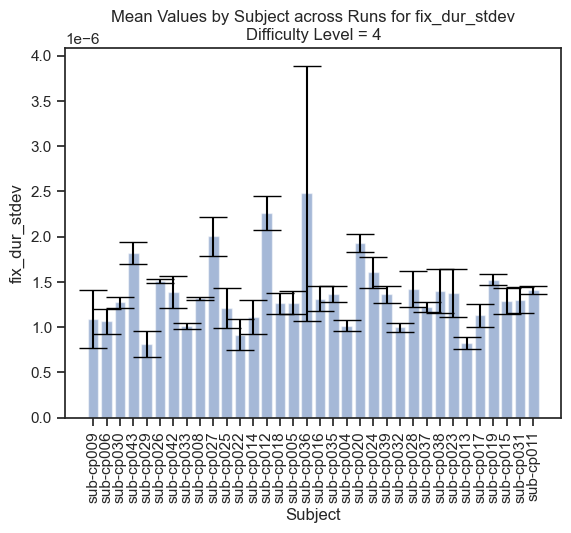

In [13]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'fix_dur_mean');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'fix_dur_mean');

plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'fix_dur_stdev');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'fix_dur_stdev');

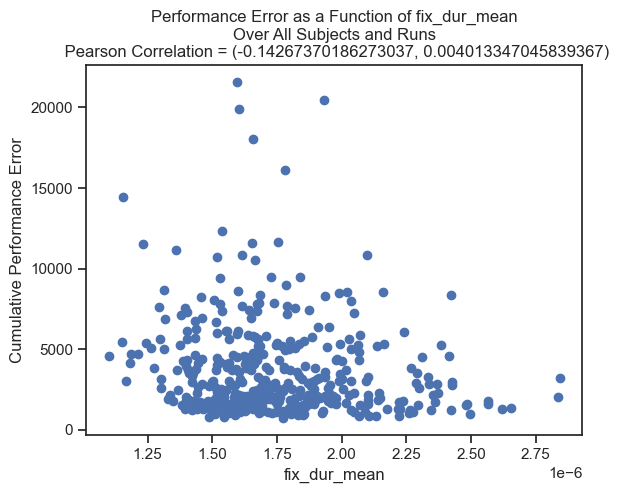

In [14]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'fix_dur_mean');

## Fixation Density 

Density of gaze points during a fixation can be useful as an indicator of focused attention [15]. We compute dispersion as a measure of density for each fixation, and the average, standard deviation, kurtosis, and skewness are provided as aggregate features over each run.

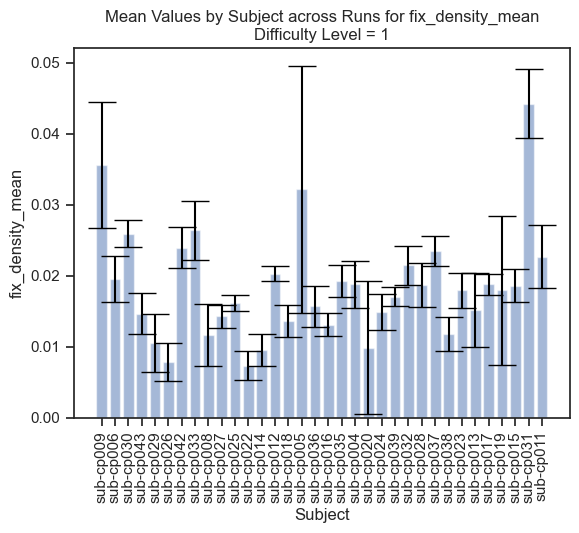

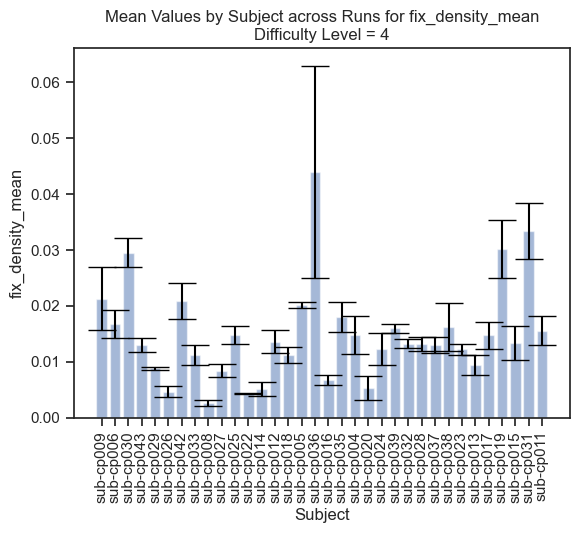

In [15]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'fix_density_mean');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'fix_density_mean');

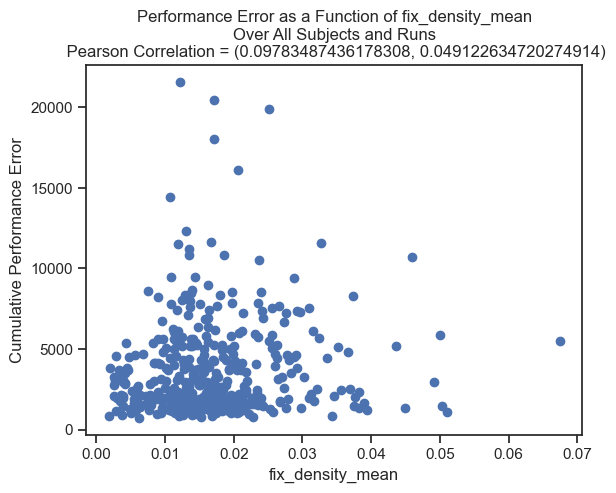

In [16]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'fix_density_mean');

## Saccade Peak Velocity

The peak velocity of a saccade can be useful as an indicator of stress, cognitive demand, and task difficulty [16]. The mean and standard deviation over all saccades in each run are provided as aggregate features.

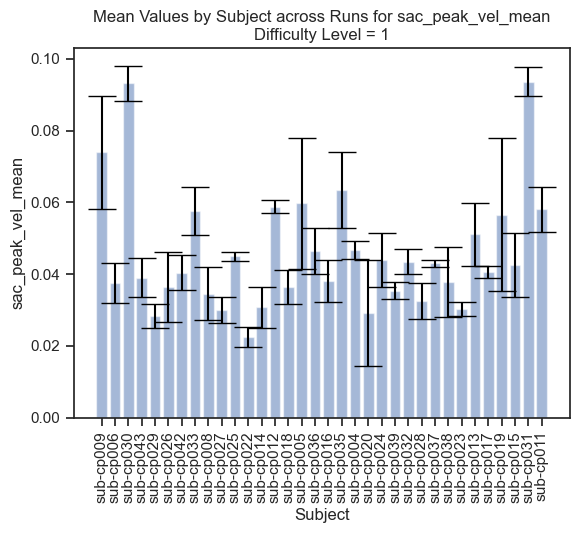

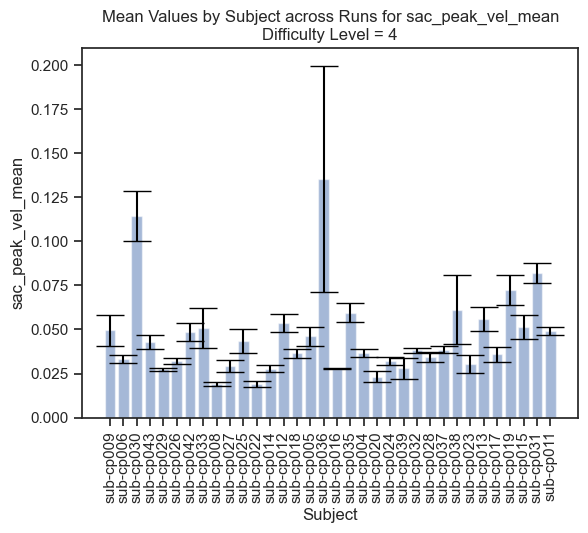

In [17]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'sac_peak_vel_mean');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'sac_peak_vel_mean');

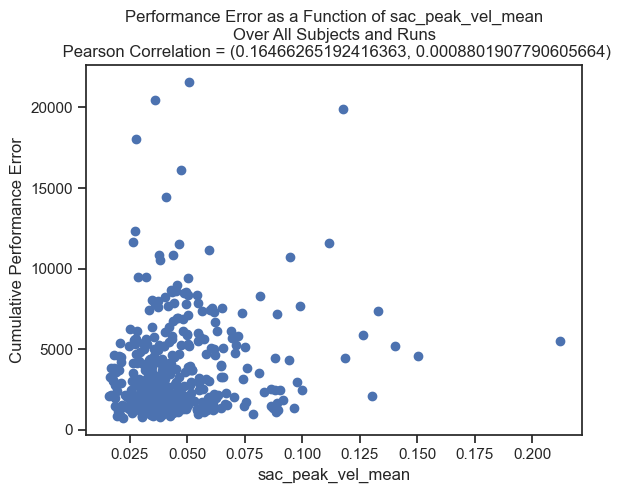

In [18]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'sac_peak_vel_mean');

## Saccade Main Sequence Slope

The Main Sequence characterizes the relationship between saccade peak velocity, duration, and amplitude and is computed as a best fit line between peak velocity x duration and amplitude for each saccade. 

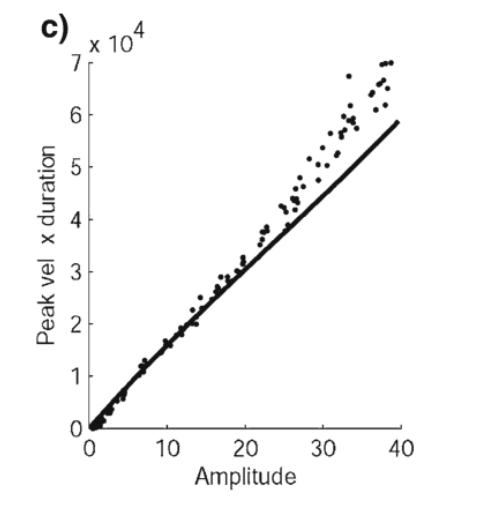

(Image from [17])

The slope of the Main Sequence is known to be sensitive to changes in mental fatigue, alertness, and cognitive load [18], and can indicate changes in psychological state when performing various tasks [19]. We provide the mean and standard deviation as aggregate features per run.


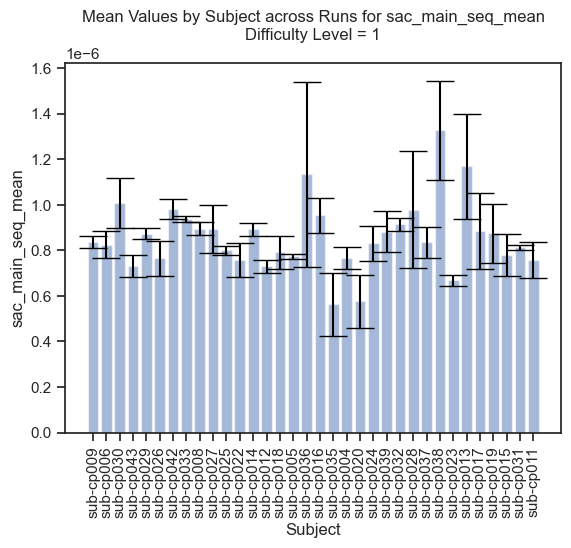

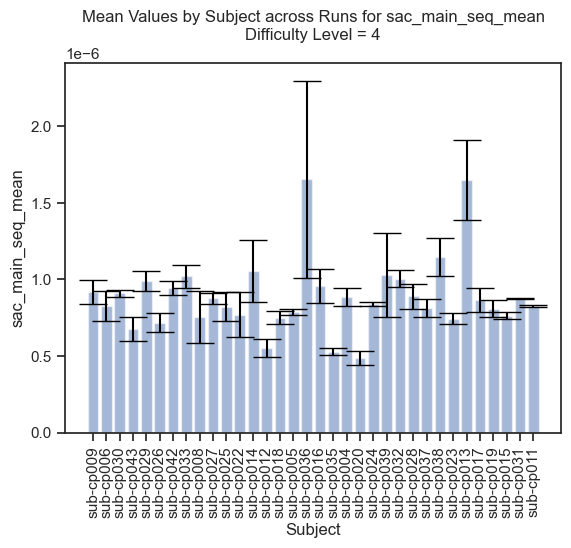

In [19]:
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 1, 'sac_main_seq_mean');
plotData.vizAggFeat_bySubj(featMatDF, perfMetricsDF, 4, 'sac_main_seq_mean');

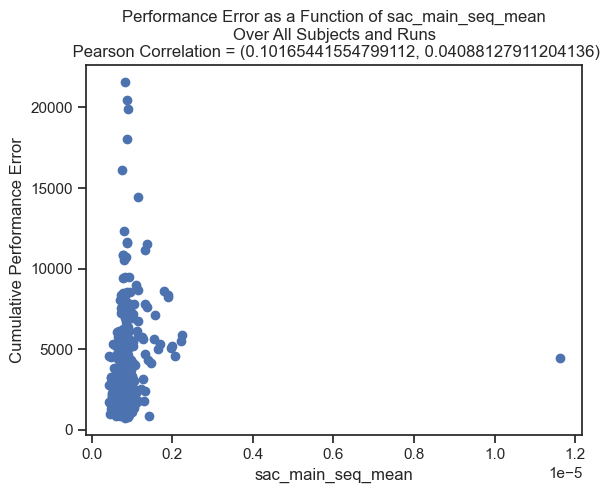

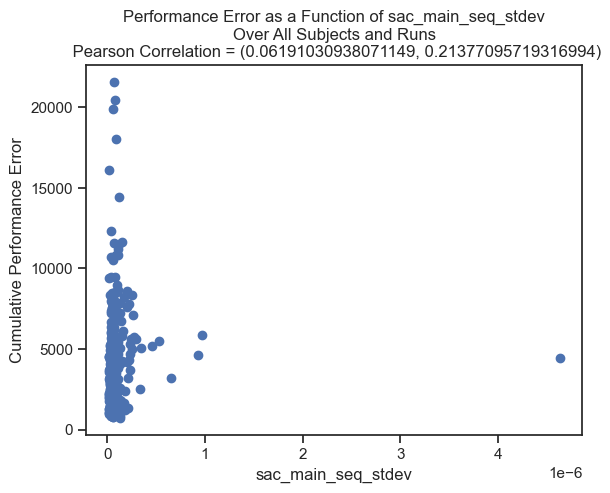

In [20]:
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'sac_main_seq_mean');
plotData.vizAggFeat_perfErr(featMatDF, perfMetricsDF, 'sac_main_seq_stdev');

# References

[1] Tole, J., Stephens, A., Vivaudou, M., Ephrath, A., & Young, L. (1983) Visual scanning behaviour and pilot workload. NASA CR-3717 technical report. MIT: Division of Health Sciences and Technology.

[2] Gilland, J. (2008) Driving, Eye-Tracking and Visual Entropy Exploration of Age and Task Effects. Doctoral Dissertation. Univ of South Dakota: Department of Psychology.

[3] Korda, A.I. et al. (2021) Recognition of Blinks Activity Patterns during Stress Conditions Using CNN and Markovian Analysis. Signals, 2, 55-71. doi: 10.3390/signals2010006 <br>

[4] Jongkees BJ, Colzato LS (2016) Spontaneous eye blink rate as predictor of dopamine-related cognitive function—A review. Neurosci Biobehavioral Rev 71:58–82. <br>
Nakano T, Kitazawa S (2010) Eyeblink entrainment at breakpoints of speech. Exp Brain Res 205:577–581. <br>

[5] Maffei A and Angrilli A. (2018) Spontaneous eye blink rate: An index of dopaminergic component of sustained attention and fatigue. Int'l Journal of Psychophysiology, 123:58-63. doi: 10.1016/j.ijpsycho.2017.11.009

[6] Nomura R, Maruno S (2019) Rapid serial blinks: An index of temporally increased cognitive load. PLoS ONE 14(12), doi: 10.1371/journal.pone.0225897

[7] Hoppe, D., Helfmann, S., and Rothkopf, C.A. (2018) Humans quickly learn to blink strategically in responds to environmental task demands. PNAS, 115 (9), doi: 10.1073/pnas.1714220115

[8] Larsen RS and Waters J. (2018) Neuromodulatory Correlates of Pupil Dilation. Frontiers in Neural Circuits, Vol 21. doi: 10.3389/fncir.2018.00021

[9] Reimer J et al. (2014) Pupil Fluctuations Track Fast Switching of Cortical States during Quiet Wakefulness, Neuron 84(2):355-362. doi: 10.1016/j.neuron.2014.09.033.

[10] Einhauser W, Stout J, Koch C, and Carter O. (2008) Pupil dilation reflects perceptual selection and predicts subsequent stability in perceptual rivalry. PNAS 105(5):1704-1709. doi: 10.1073/pnas.0707727105 

[11] Gegenfurtner KR. The Interaction Between Vision and Eye Movements. Perception (2016).
https://journals.sagepub.com/doi/pdf/10.1177/0301006616657097

[12] Purves D, et al. Neuroscience, 2nd Edition. Sinauer Associates (2001).

[13] Tulunay-Keesey U. Fading of stabilized retinal images. J Opt Soc Am (1982).
https://www.ncbi.nlm.nih.gov/pubmed/7077431

[14] Ghose U, Srinivasan AA, Boyce WP, Xu H, and Chng ES. PyTrack: An end-to-end analysis toolkit for eye tracking. Behavior Research Methods (2020). doi: 10.3758/s13428-020-01392-6 

[15] Wen Liu, Soussan Djamasbi, Andrew C. Trapp, and Mina Shojaeizadeh. Measuring focused attention using fixation inner-density. Int'l Conference on Augmented Cognition (2018). doi: 10.1007/978-3-319-91467-1_9

[16] Di Stasi LL et al. Saccadic velocity as an arousal index in naturalistic tasks. Neuroscience and Biobehavioral Reviews (2013). doi: 10.1016/j.neubiorev.2013.03.011

[17] Harris C and Wolpert D. The Main Sequence of Saccades Optimizes Speed-accuracy Trade-off. Biological Cybernetics, 95 (2006). doi: 10.1007/s00422-006-0064-x

[18] Di Stasi LL et al. Towards a driver fatigue test based on the saccadic main sequence: A partial validation by subjective report data. Transportation Research (2012). doi: 10.1016/j.trc.2011.07.002

[19] Bahill AT, Clark MR, and Stark L. The main sequence, a tool for studying human eye movements. Mathematical Biosciences, 24 (1975). doi: 10.1016/0025-5564(75)90075-9

Research was sponsored by the United States Air Force Research Laboratory and the United States Air Force Artificial Intelligence Accelerator and was accomplished under Cooperative Agreement Number FA8750-19-2-1000. The views and conclusions contained in this document are those of the authors and should not be interpreted as representing the official policies, either expressed or implied, of the United States Air Force or the U.S. Government. The U.S. Government is authorized to reproduce and distribute reprints for Government purposes notwithstanding any copyright notation herein.